# Machine Learning - Practical 4

Names: Jakob Dieterle, Andre Buderus, Jonas Willms

In [48]:
!pip install cvxopt
!pip install graphviz

In [49]:
import numpy as np
import cvxopt
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier

## Task 0: The Data

We will work with the data from Practical 3. Load the data and split it into a training and test set. You can re-use the data splitting function from Practical 2.

In [50]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # ---------------- INSERT CODE ----------------------

    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

    test_idx = idx_shuffled[:int(X.shape[0]*frac)]
    train_idx = idx_shuffled[int(X.shape[0]*frac):X.shape[0]]

    X_test = X[test_idx]
    y_test = y[test_idx]
    print('Test set shapes (X and y)', X_test.shape, y_test.shape)

    X_train = X[train_idx]
    y_train = y[train_idx]
    print('Training set shapes (X and y):', X_train.shape, y_train.shape)

    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test

In [51]:
# load data
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:,:2], np.load('nonlin_2d_data.npy')[:, 2]

In [52]:
# split data
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)

Test set shapes (X and y) (75, 2) (75,)
Training set shapes (X and y): (175, 2) (175,)


## Task 1: Support Vector Machines

First, you will implement a training algorithm for the Support Vector Machine (SVM). For solving the quadratic program, we provide a simple interface to the cvxopt library below.

In SVMs, each data sample $x_n$ has a corresponding lagrange multiplier $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha + \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ (the intercept or bias) and $h$ are vectors with one element per individual constraint.

Having trained the SVM, a prediction for an input $\mathbf{x}$ is made by:

$$ y = sign([\sum_n^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n)] + b)  $$


### Task 1.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver. Fit a SVM on the training data and extract its parameters using a linear kernel (dot product).

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.
  - The SVM is described in chapter 12 of Elements of Statistical Learning.

In [53]:
def linear_kernel(a, b):
    return a.dot(b.T)


def fit_svm(X, t, kernel, C=1.0):
    '''Fit SVM using data (X,t), specified kernel and parameter C.
    Inputs
        X:  predictors
        t:  targets
        C:  constant
    '''

    t = np.array([-1 if l == 0 else 1 for l in t])
    n_samples, n_features = X.shape
    t = t.reshape(-1,1) * 1.
    
    P = np.dot(t, t.T) * kernel(X,X)
    q = np.ones(n_samples) * -1
    A = t.T
    b = np.diag(np.zeros(1))
    G = np.vstack((np.eye(n_samples) * -1, np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))
    
    assert P.shape == (len(X), len(X))
    assert len(q) == len(X)
    assert A.shape == (1, n_samples) and A.dtype == 'float'
    assert b.shape == (1, 1)
    assert len(G) == 2 * len(X)
    assert len(h) == 2 * len(X)

    return solve_quadratic_program(P, q, A, b, G, h)

def solve_quadratic_program(P, q, A, b, G, h):
    '''Uses cvxopt to solve the quadratic program.'''
    P, q, A, b, G, h = [cvxopt.matrix(var) for var in [P, q, A, b, G, h]]
    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
    lagr_mult = np.ravel(minimization['x'])
    return lagr_mult


def extract_parameters(X, t, kernel, lagr_mult, threshold=1e-7):
    '''Computes the intercept from the support vector constraints.
    
    Inputs
        X:         predictors
        t:         targets
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        threshold: threshold for choosing support vectors
    
    Returns
        lagr_mult: lagrange multipliers for the support vectors
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept (also called bias)
    '''
    t = np.array([-1 if l == 0 else 1 for l in t])
    
    # ---------------- INSERT CODE ----------------------

    #w parameter in vectorized form
    w = ((t * lagr_mult).T @ X).reshape(-1,1)

    #Selecting the set of indices S corresponding to non zero parameters
    S = (lagr_mult > 1e-4).flatten()
    svs = X[S]
    sv_labels = t[S]
    lagr_mult = lagr_mult[S]

    #Computing intercept
    #intercept = sv_labels - np.dot(X[S], w)
    intercept = sv_labels - np.sum(lagr_mult * sv_labels * kernel(svs, svs), axis=0)
    intercept = np.sum(intercept) / intercept.size


    # ---------------- END CODE -------------------------

    return lagr_mult, svs, sv_labels, intercept


In [54]:
# Training
# Fit SVM on training data
lagr_mult = fit_svm(X_train, t_train, linear_kernel)

# Extract parameters
lagr_mult, svs, sv_labels, intercept = extract_parameters(X_train, t_train, linear_kernel, lagr_mult)

     pcost       dcost       gap    pres   dres
 0: -1.6799e+02 -3.7889e+02  9e+02  2e+00  2e-14
 1: -1.2879e+02 -2.5279e+02  1e+02  2e-15  1e-14
 2: -1.3986e+02 -1.4886e+02  9e+00  6e-15  1e-14
 3: -1.4000e+02 -1.4009e+02  9e-02  7e-15  1e-14
 4: -1.4000e+02 -1.4000e+02  9e-04  4e-15  1e-14
 5: -1.4000e+02 -1.4000e+02  9e-06  3e-15  1e-14
Optimal solution found.


### Task 1.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function with the linear kernel and compute the test accuracy on the 2d dataset.
- Visualize the samples form the test set in a scatter plot colored by your predictions

In [55]:
def svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept):
    ''' Given the learned parameters of the SVM, make a prediction on the test set.
    Inputs
        X:         predictors
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept (also called bias)
    
    Returns
        prediction: predictions on novel samples
    '''  
    
    # ---------------- INSERT CODE ----------------------
    n_samples, n_features = X.shape
    
    y_pred = []
    for x_m in X:
        y_sum = 0
        for x_n, an, tn in zip(svs, lagr_mult, sv_labels):
            y_sum = y_sum + an*tn*kernel(x_m, x_n)
        y_pred.append(y_sum)

    prediction = np.sign(y_pred + intercept)
    # ---------------- END CODE -------------------------
    
    return prediction

In [56]:
# Testing
# make predictions for test set
pred = svm_predict(X_test, linear_kernel, lagr_mult, svs, sv_labels, intercept)
print(pred)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


In [57]:
# visualize predictions
pred1 = []
pred2 = []

threshold = 0

for i in range(len(pred)):
    if pred[i] >= threshold:
        pred1.append(X_test[i])
    else:
        pred2.append(X_test[i])


plt.scatter([i[0] for i in pred1], [i[1] for i in pred1])
plt.scatter([i[0] for i in pred2], [i[1] for i in pred2])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("Classification with linear kernel")

Text(0.5, 1.0, 'Classification with linear kernel')

### Task 1.3

- Instead of using the linear kernel, use the Gaussian RBF kernel defined in Practical 3.
- Compare results on with both kernels with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary for both kernels (Hint: Adapt the decision boundary plot from Practical 3).

In [58]:
def rbf_kernel(a, b, gamma = 1):
    # ---------------- INSERT CODE ----------------------

    return np.exp(-1 * gamma * np.linalg.norm(a - b)**2)


    # ---------------- END CODE -------------------------

In [59]:
# Fit SVM with rbf kernel and calculate the test accuracy
lagr_mult = fit_svm(X_train, t_train, rbf_kernel)

# Extract parameters
lagr_mult, svs, sv_labels, intercept = extract_parameters(X_train, t_train, rbf_kernel, lagr_mult)

pred = svm_predict(X_test, rbf_kernel, lagr_mult, svs, sv_labels, intercept)


pred1 = []
pred2 = []

threshold = 0

for i in range(len(pred)):
    if pred[i] >= threshold:
        pred1.append(X_test[i])
    else:
        pred2.append(X_test[i])


plt.scatter([i[0] for i in pred1], [i[1] for i in pred1], color = 'r')
plt.scatter([i[0] for i in pred2], [i[1] for i in pred2], color = 'b')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("Classification with rbf kernel")

     pcost       dcost       gap    pres   dres
 0: -1.6800e+02 -3.7800e+02  9e+02  2e+00  4e-15
 1: -1.2889e+02 -2.5208e+02  1e+02  7e-16  3e-15
 2: -1.3989e+02 -1.4859e+02  9e+00  3e-15  2e-15
 3: -1.4000e+02 -1.4009e+02  9e-02  1e-15  4e-15
 4: -1.4000e+02 -1.4000e+02  9e-04  4e-15  2e-15
 5: -1.4000e+02 -1.4000e+02  9e-06  3e-15  4e-15
Optimal solution found.


Text(0.5, 1.0, 'Classification with rbf kernel')

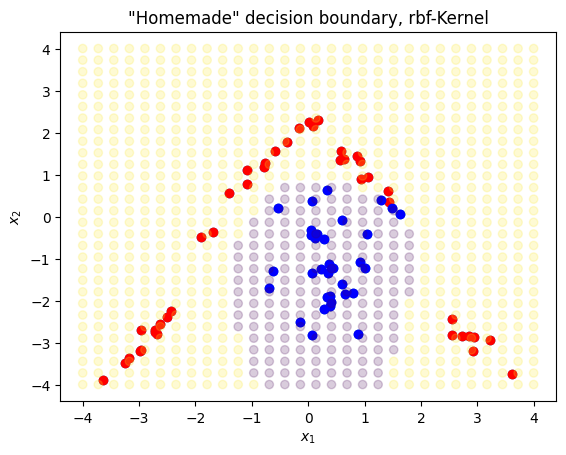

In [60]:
def pred_rbf(X):
    return svm_predict(X, rbf_kernel, lagr_mult, svs, sv_labels, intercept)

def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn(np.array([[x, y] for x, y, in zip(grid_x, grid_y)]))])
    return plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


plt.title('"Homemade" decision boundary, rbf-Kernel')
plt.show(plot_decision_boundary(pred_rbf))



In [61]:
# Fit SVM using sklearn and calculate the test accuracy
clf_linear = SVC(kernel='linear')
clf_rbf = SVC(kernel='rbf')

clf_linear.fit(X_train, t_train)
clf_rbf.fit(X_train, t_train)

pred_svc_linear = clf_linear.predict(X_test)
pred_svc_rbf = clf_rbf.predict(X_test)

print("Score using a linear kernel =",clf_linear.score(X_test, t_test))
print("\nScore using an rbf kernel =",clf_rbf.score(X_test, t_test))

Score using a linear kernel = 0.6

Score using an rbf kernel = 1.0


In [62]:
# Visualize
fig1, axs1 = plt.subplots(1,2, figsize = (12,5))
fig1.suptitle('SKlearn Linear')
axs1[0].scatter(X_test[(pred_svc_linear == 1)][:,0], X_test[(pred_svc_linear == 1)][:,1], label = 'predicted 1')
axs1[0].scatter(X_test[(pred_svc_linear == 0)][:,0], X_test[(pred_svc_linear == 0)][:,1], label = 'predicted 0')
axs1[0].scatter(clf_linear.support_vectors_[:,0],clf_linear.support_vectors_[:,1], label = 'support vectors', marker = "x")
axs1[0].legend()
axs1[1].set(title = 'decision boundarys')
axs1[1]= plot_decision_boundary(clf_linear.predict)


fig2, axs2 = plt.subplots(1,2, figsize = (12,5))
fig2.suptitle('SKlearn rbf')
axs2[0].scatter(X_test[(pred_svc_rbf == 1)][:,0], X_test[(pred_svc_rbf == 1)][:,1], label = 'predicted 1')
axs2[0].scatter(X_test[(pred_svc_rbf == 0)][:,0], X_test[(pred_svc_rbf == 0)][:,1], label = 'predicted 0')
axs2[0].scatter(clf_rbf.support_vectors_[:,0],clf_rbf.support_vectors_[:,1], label = 'support vectors', marker = "x")
axs2[0].legend()
axs2[1].set(title = 'decision boundarys')
axs2[1] = plot_decision_boundary(clf_rbf.predict)


# Task 2: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples, i.e. between `t[:50]` and `t[50:]`.

In [63]:
# Load Wine dataset and split into train+test set

X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X, t)

Test set shapes (X and y) (53, 13) (53,)
Training set shapes (X and y): (125, 13) (125,)


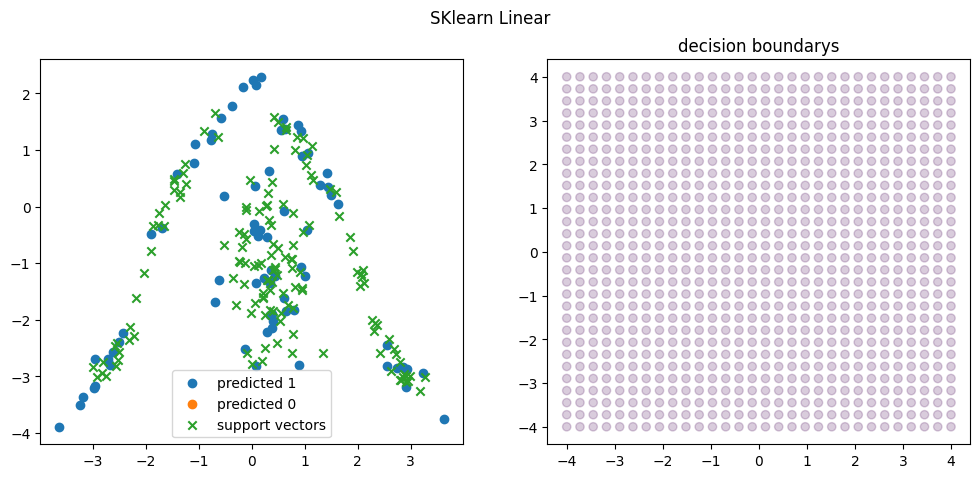

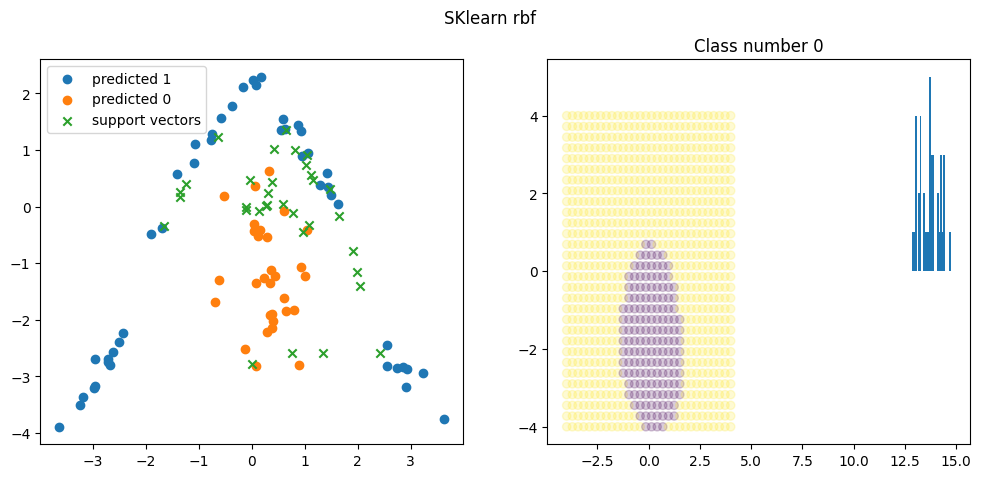

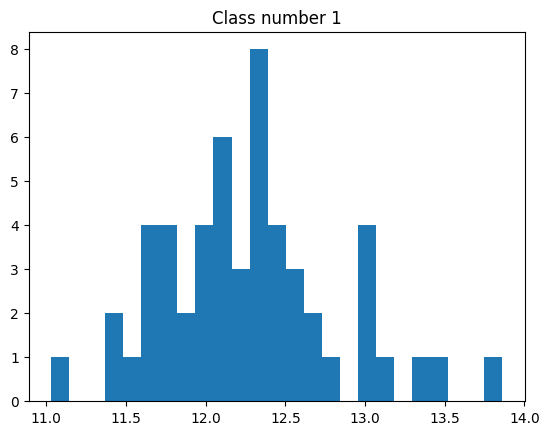

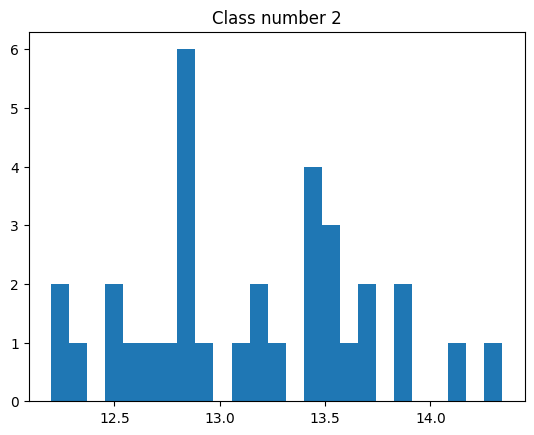

In [64]:
# Plot distribution
for i in range(3):
    plt.title(f'Class number {i}')
    plt.show(plt.hist((X_train[t_train == i])[:,0], label = f"{i}", bins = 25))

In [65]:
# Compute Gini impurity
def gini_impurity(t):
    _, t_uniq = np.unique(t,return_counts=True)
    n = len(t)
    G = 0
    
    for i in t_uniq:
        p = i/n
        G += p * (1-p)

    return G

### just checking
t1 = [0,0,0,1,1,1]
t2 = [0,0,2,2,1,1]
print(f"Testing:\nshould be:0.5  is: {gini_impurity(t1)} \nshould be:2/3  is: {gini_impurity(t2)}" )



Testing:
should be:0.5  is: 0.5 
should be:2/3  is: 0.6666666666666667


### Task 2.2
For each of the first 12 features, compute the remove Gini impurity for every possible split. Visualize the removed Gini impurity per feature across all splits. Which is the optimal split?

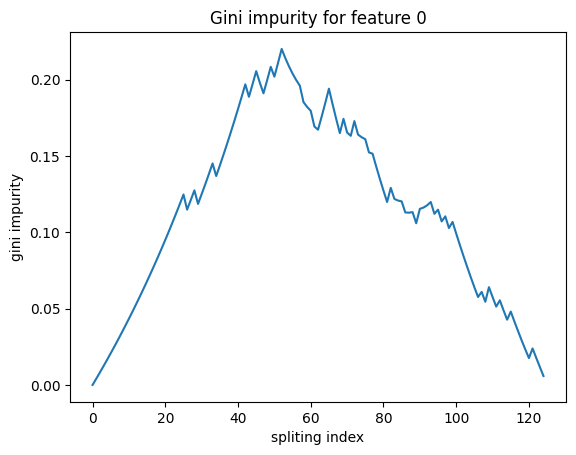

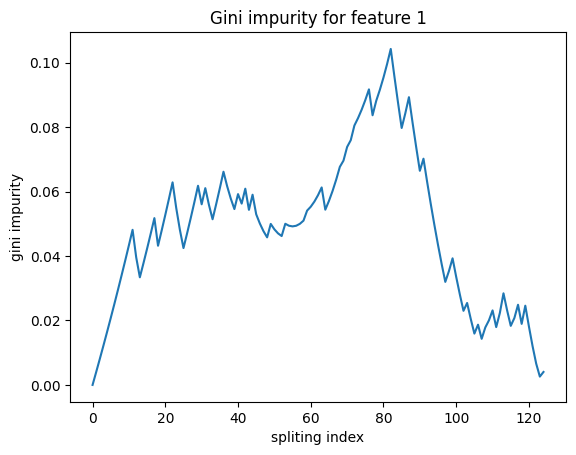

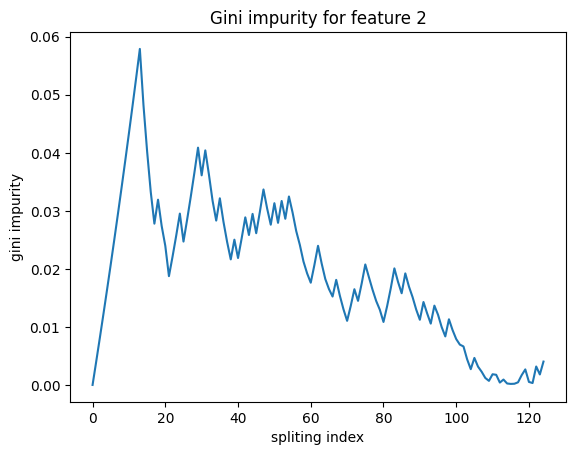

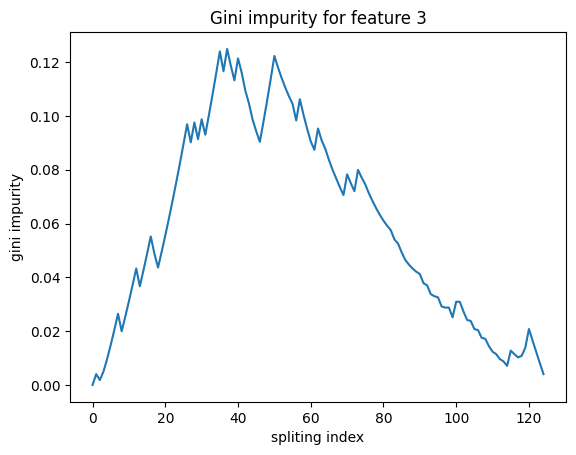

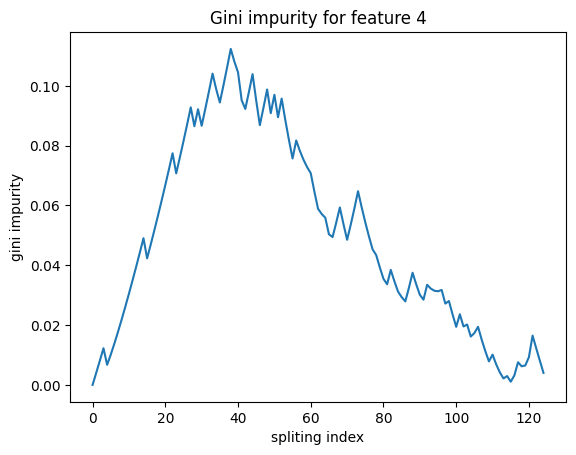

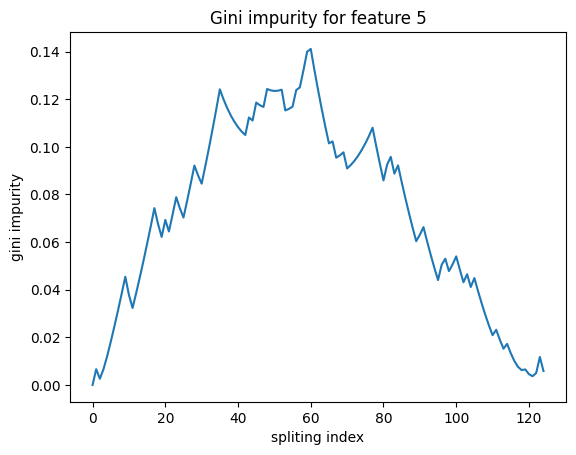

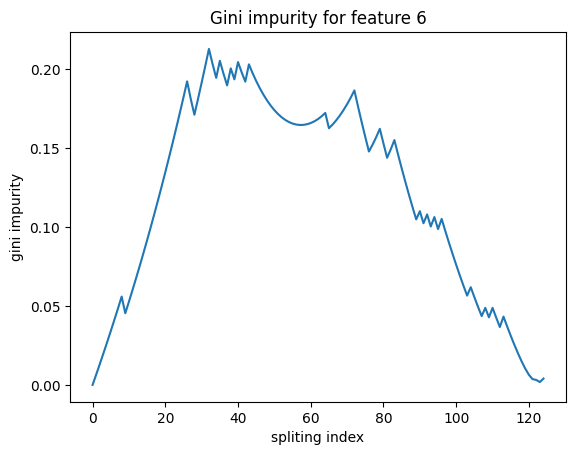

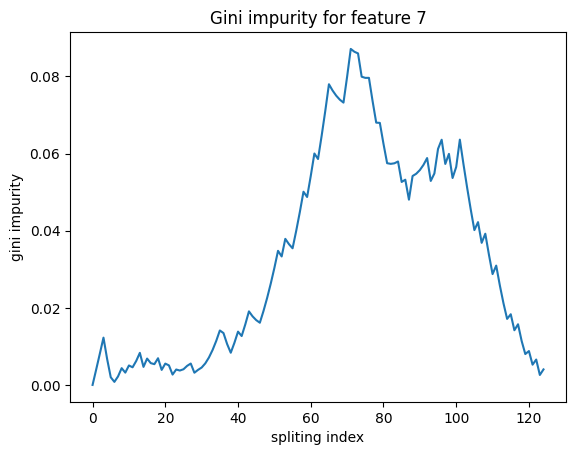

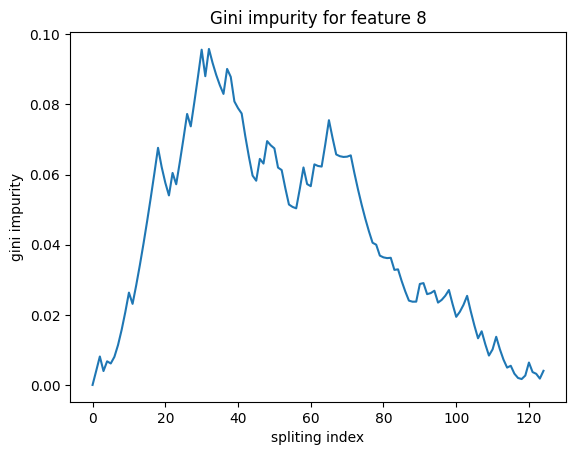

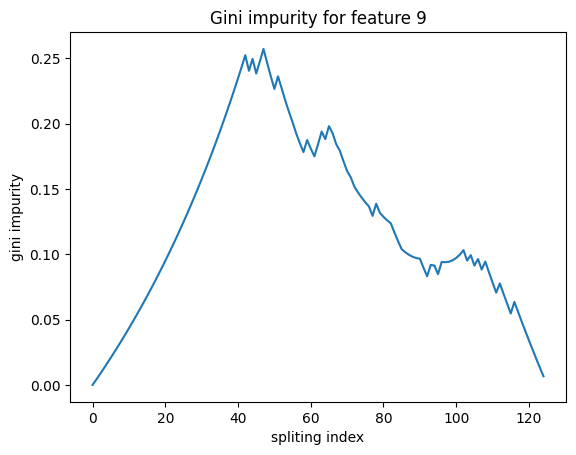

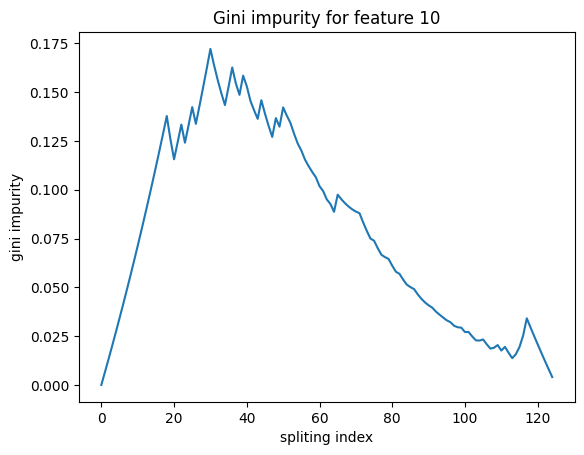

In [66]:
# Plotting
for h in range(12): #technically those are the first 13
    x = X_train[:,h]
    idx = np.argsort(x)
    
    gi = []

    x_s = x[idx]
    t_s = t_train[idx]
    G_0 = gini_impurity(t_s)
    n = len(x_s)

    for i in range(len(x_s)):
        gi.append(G_0 - i/n * gini_impurity(t_s[:i]) - (n-i)/n * gini_impurity(t_s[i:]))

    plt.plot(gi)
    plt.title(f'Gini impurity for feature {h}')
    plt.xlabel('spliting index')
    plt.ylabel('gini impurity')
    plt.show()


### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [67]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label


In [68]:
# Implement recursive tree function

def build_tree(X, t, depth, max_depth=3, n_labels=2):
    
    # ---------------- INSERT CODE ----------------------
    if len(t)==1:
        return Leaf(t)
    
    G = gini_impurity(t)
    max_gain = 0
    max_dim = -1
    max_threshold = -1
    for d in range(len(X[0])):
        x = X[:,d]
        idx = np.argsort(x)
        x_s = x[idx]
        t_s = t[idx]
        gg = 0
        threshold = -1
        for i in range(0,len(t_s)):
            left = t_s[0:i]
            right = t_s[i:]
            g_new = G-(((len(left)/len(x))*gini_impurity(left))+((len(right)/len(x))*gini_impurity(right)))
            #print(g_new)
            if g_new > gg: 
                #print(g_new, i)
                gg = g_new
                threshold = x_s[i] 
                
        if gg > max_gain:
            
            max_gain = gg
            max_dim = d
            max_threshold = threshold
  
    Xl = X[X[:,max_dim]<max_threshold,:]
    tl = t[X[:,max_dim]<max_threshold]
    Xr = X[X[:,max_dim]>=max_threshold,:]
    tr = t[X[:,max_dim]>=max_threshold]
    depth+=1
    if depth<max_depth and max_dim != -1:
        left_child = build_tree(Xl,tl,depth,max_depth,n_labels)
        right_child = build_tree(Xr,tr,depth,max_depth,n_labels)
    else:
        u, c = np.unique(t, return_counts=True)
        return Leaf(u[np.argmax(c)])
    return Node(left_child, right_child, max_dim, max_threshold)

    # ---------------- END CODE -------------------------

    
def predict_tree(node, x):
    
    # ---------------- INSERT CODE ----------------------
    if isinstance(node, Leaf):
        return node.label
    if x[node.n_feat] < node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)
    # ---------------- END CODE -------------------------

In [69]:
# Build tree
tree_scratch = build_tree(X_train, t_train, 0, max_depth=3, n_labels=3)

In [70]:
# Calculate training and test scores
b=0
m=X_train.shape[0] # Number of samples
for i in range(m):
    if predict_tree(tree_scratch, X_train[i])==t_train[i]:
        b += 1
print('Training score')
print(b,m)
print(b/m)

a=0
n=X_test.shape[0] # Number of samples
for i in range(n):
    if predict_tree(tree_scratch, X_test[i])==t_test[i]:
        a += 1
print('Test score')
print(a,n)
print(a/n)



Training score
115 125
0.92
Test score
47 53
0.8867924528301887


In [71]:
# Calculate test score using sklearn
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, t_train)
a=0
m=X_test.shape[0]
for i in range(n):
    if clf.predict(X_test[i].reshape(1,-1)) == t_test[i]:
        a+=1

print('Test score')
print(a,m)
print(a/m)

Test score
51 53
0.9622641509433962


In [72]:
# Calculate test score for synthetic 2D dataset
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:,:2], np.load('nonlin_2d_data.npy')[:, 2]
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, t_train)

score = clf.score(X_test, t_test) 
print(score)

Test set shapes (X and y) (75, 2) (75,)
Training set shapes (X and y): (175, 2) (175,)
0.96


In [73]:
# Visualize
import graphviz
data = load_wine()
dot_data = tree.export_graphviz(clf, out_file=None, class_names=data.target_names, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("iris")
display(graph)